In [1]:
from tensorflow.data import TextLineDataset
from functools import partial
import os
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from utils.retina import RetinaNet, PredictionDecoder
from utils.generator import preprocess_data_from_textline
from utils.box import resize_and_pad_image, visualize_detections

In [2]:
val_dataset  = TextLineDataset(filenames='data/annot_val.txt')
val_path = "C:/Users/HP/work/data/image/synthetic/val"
val_dataset = val_dataset.map(lambda x: preprocess_data_from_textline(x, val_path))

In [3]:
train_dataset  = TextLineDataset(filenames='data/annot_train.txt')
train_path = "C:/Users/HP/work/data/image/synthetic/train"
train_dataset = train_dataset.map(lambda x: preprocess_data_from_textline(x, train_path))

In [4]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, jitter=None)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

In [5]:
model = RetinaNet(4)
latest_checkpoint = tf.train.latest_checkpoint('models/')
model.load_weights(latest_checkpoint)

In [6]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = PredictionDecoder(num_classes=4, confidence_threshold=0.2)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

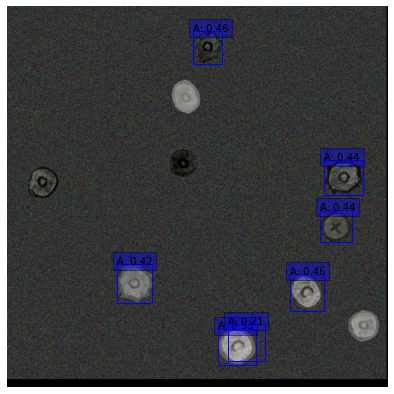

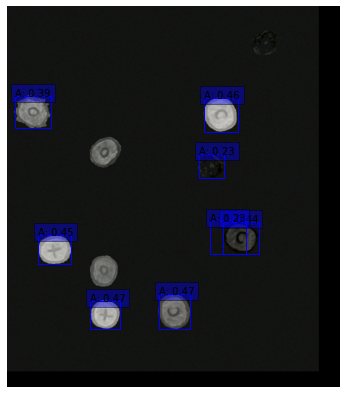

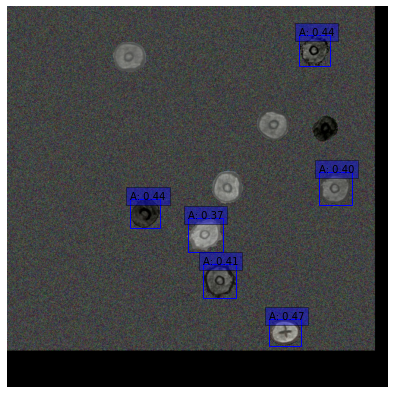

In [7]:
for sample in val_dataset.take(3):
    original_image = sample[0]
    input_image, ratio = prepare_image(original_image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = ['A'] * num_detections
    score = [1] * num_detections
    visualize_detections(original_image, detections.nmsed_boxes[0][:num_detections] / ratio,
                         class_names, detections.nmsed_scores[0][:num_detections])